In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import warnings

warnings.filterwarnings("ignore") 
plt.rcParams['font.size'] = 10

In [4]:
# Define directories
train_dir = r"/Users/anshmadan/Coding/IML Final Project/Birds_25/train"
valid_dir = r"/Users/anshmadan/Coding/IML Final Project/Birds_25/valid"

# Get class names from directory names
class_names = [cls for cls in os.listdir(train_dir) if not cls.startswith('.')]
num_classes = len(class_names)

print("Class names:", class_names)

Class names: ['Coppersmith-Barbet', 'Cattle-Egret', 'White-Breasted-Waterhen', 'Asian-Green-Bee-Eater', 'Common-Myna', 'Hoopoe', 'Gray-Wagtail', 'Jungle-Babbler', 'White-Wagtail', 'Common-Tailorbird', 'Common-Rosefinch', 'Rufous-Treepie', 'Ruddy-Shelduck', 'Sarus-Crane', 'Red-Wattled-Lapwing', 'Common-Kingfisher', 'House-Crow', 'White-Breasted-Kingfisher', 'Forest-Wagtail', 'Northern-Lapwing', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Grey-Hornbill', 'Brown-Headed-Barbet', 'Indian-Roller']


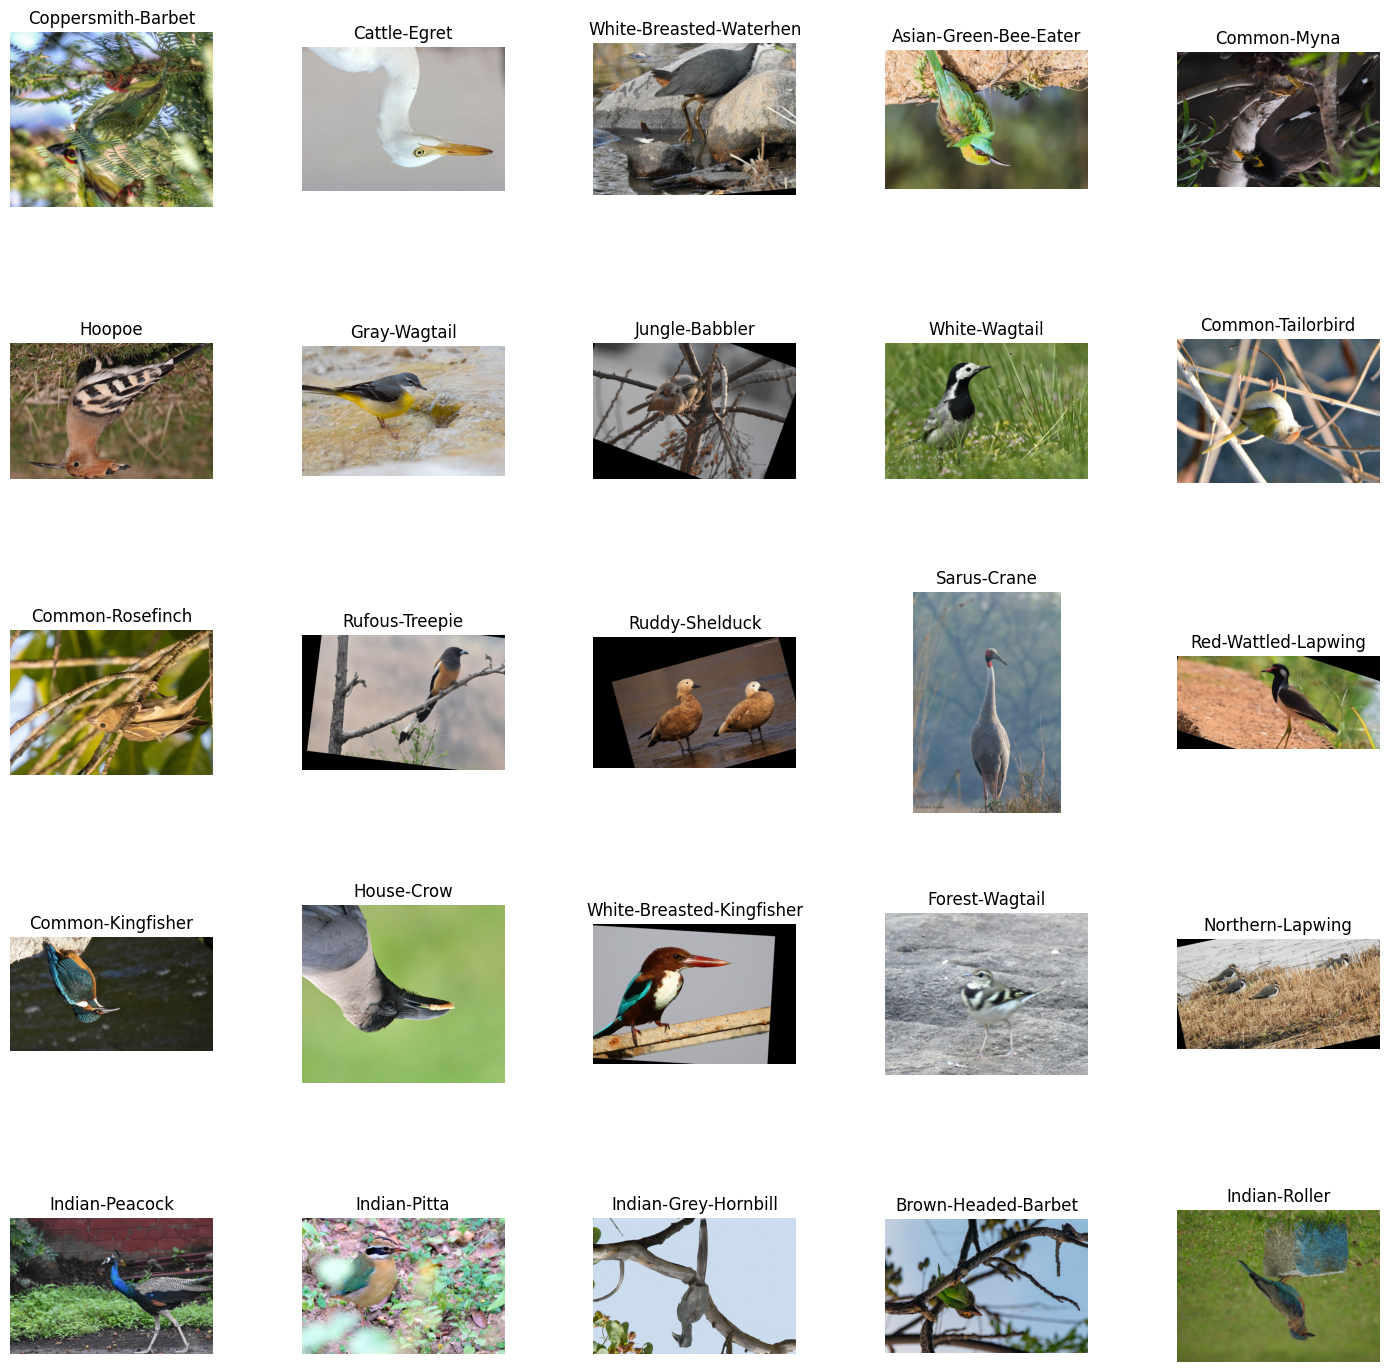

In [22]:
# Visualize sample images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
fig.tight_layout(pad=3.0)

for i, cls in enumerate(class_names[:25]):  # Ensure not exceeding subplot limits
    ax = axs[i // 5][i % 5]
    cls_path = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(cls)

plt.show()

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)

Found 30000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.


In [28]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze the base model

In [29]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',          # Updated filepath
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

In [31]:
# Calculate steps
train_steps = train_generator.samples // train_generator.batch_size
valid_steps = valid_generator.samples // valid_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
 17/937 ━━━━━━━━━━━━━━━━━━━━ 32:29 2s/step - accuracy: 0.0788 - loss: 3.9176

KeyboardInterrupt: 